In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, time, sys
import psutil
from datetime import timedelta

import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns

import pcms.haar
import pcms.tree
import kspt
import utils

In [3]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Verify functionality of CDF estimator

### Random topology CDF

#### Evaluate at a single point

In [19]:
n_leaves = 1000
f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g
y = 0.01

In [20]:
start = time.time()
cdf_val_cbst = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
print("Elapsed time: ", time.time() - start)

Elapsed time:  3.3194479942321777


In [21]:
print(cdf_val_cbst)

1.0


#### Estimate time complexity

In [22]:
process = psutil.Process()

sizes1 = np.logspace(1, 5, num=15, dtype=int)
times1 = []
memories1 = []

for n_leaves in sizes1:
    f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
    g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
    func = f - g
    y = 0.01

    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times1.append(elapsed)
    memories1.append(mem_after - mem_before)  # memory difference in MB

    print(f"n_leaves = {n_leaves:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

n_leaves =      10 | time = 0.42743 sec | memory change = -0.01 MB
n_leaves =      19 | time = 0.43613 sec | memory change = 0.00 MB
n_leaves =      37 | time = 0.50831 sec | memory change = 0.00 MB


KeyboardInterrupt: 

Fit: T(n) ≈ 0.00345485 * n^1.01 (after burn-in=5)


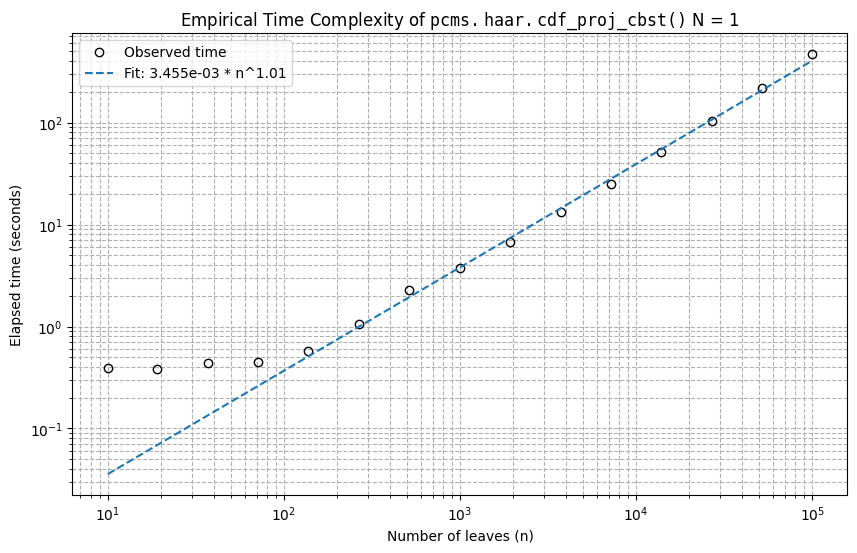

In [ ]:
burn_in = 5

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes1)
log_times = np.log10(times1)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes1**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes1, times1,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes1, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Number of leaves (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

In [ ]:
process = psutil.Process()

sizes2 = np.logspace(1, 8, num=15, dtype=int)
times2 = []
memories2 = []
n_leaves = 1000

f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g

for n_points in sizes2:
    y = np.linspace(0, 0.1, n_points)

    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times2.append(elapsed)
    memories2.append(mem_after - mem_before)  # memory difference in MB

    print(f"n_points = {n_points:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

n_points =      10 | time = 3.96964 sec | memory change = 0.21 MB
n_points =      31 | time = 3.83084 sec | memory change = 0.00 MB
n_points =     100 | time = 3.84262 sec | memory change = 0.00 MB
n_points =     316 | time = 3.79303 sec | memory change = 0.00 MB
n_points =    1000 | time = 4.36598 sec | memory change = -0.01 MB
n_points =    3162 | time = 3.92913 sec | memory change = 0.01 MB
n_points =   10000 | time = 3.94084 sec | memory change = 0.00 MB
n_points =   31622 | time = 3.96067 sec | memory change = -0.01 MB
n_points =  100000 | time = 4.03930 sec | memory change = 11.40 MB
n_points =  316227 | time = 4.07176 sec | memory change = 4.17 MB
n_points = 1000000 | time = 4.11871 sec | memory change = 19.50 MB
n_points = 3162277 | time = 3.72065 sec | memory change = 23.71 MB
n_points = 10000000 | time = 3.77556 sec | memory change = 52.20 MB
n_points = 31622776 | time = 3.84717 sec | memory change = 164.97 MB
n_points = 100000000 | time = 4.30723 sec | memory change = 521.68

Fit: T(n) ≈ 3.91876 * n^0.00 (after burn-in=0)


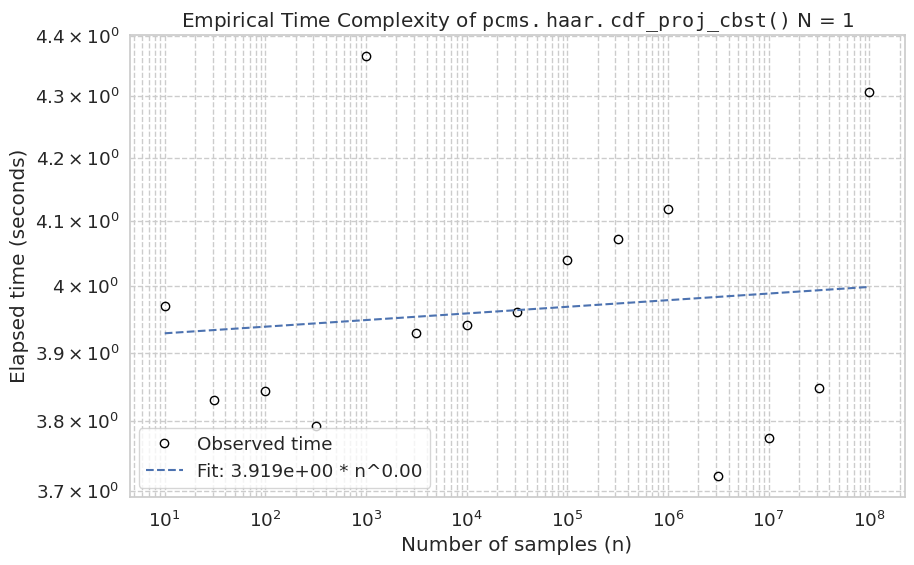

In [ ]:
burn_in = 0

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes2)
log_times = np.log10(times2)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes2**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes2, times2,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes2, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Number of samples (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

In [ ]:
process = psutil.Process()

sizes3 = np.logspace(0, 3, num=8, dtype=int)
times3 = []
memories3 = []
n_leaves = 1000
y = 0.01

f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g

for batch_size in sizes3:
    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=batch_size)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times3.append(elapsed)
    memories3.append(mem_after - mem_before)  # memory difference in MB

    print(f"batch_size = {batch_size:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

batch_size =       1 | time = 35.67350 sec | memory change = 0.00 MB
batch_size =       2 | time = 19.26267 sec | memory change = 0.00 MB
batch_size =       7 | time = 10.23794 sec | memory change = 0.20 MB
batch_size =      19 | time = 7.44545 sec | memory change = -0.01 MB
batch_size =      51 | time = 5.21468 sec | memory change = -0.02 MB
batch_size =     138 | time = 4.30055 sec | memory change = 0.01 MB
batch_size =     372 | time = 3.82171 sec | memory change = 0.01 MB
batch_size =    1000 | time = 3.41441 sec | memory change = 0.00 MB


Fit: T(n) ≈ 23.9613 * n^-0.33 (after burn-in=0)


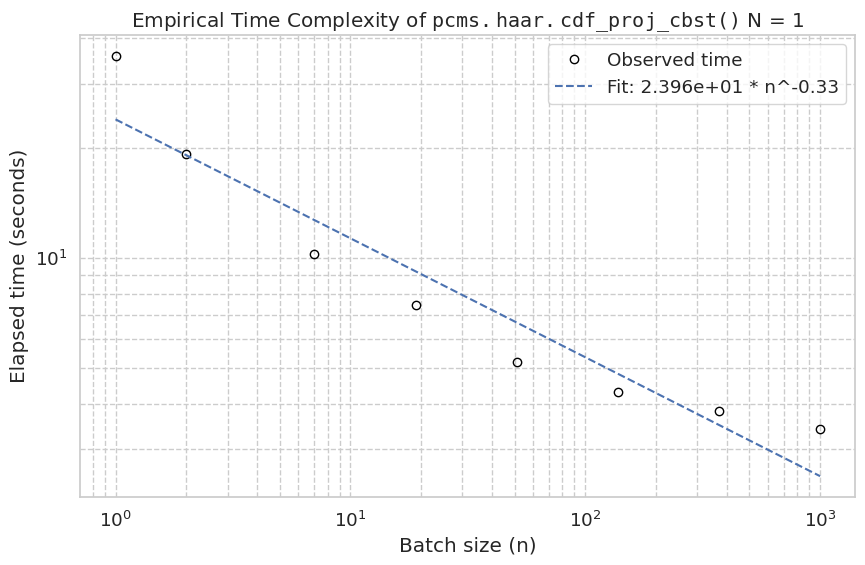

In [ ]:
burn_in = 0

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes3)
log_times = np.log10(times3)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes3**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes3, times3,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes3, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Batch size (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

#### Evaluate at multiple points

In [ ]:
n_points = 1000
ys_cbst = np.linspace(-0.0001, 0.0001, n_points)

In [ ]:
cdf_vals_cbst = pcms.haar.cdf_proj_cbst(ys_cbst, func, eps=0.005, delta=0.01)

In [ ]:
quantile_levels = [0.5, 0.8, 0.9, 0.95]
quantiles_cbst = np.interp(quantile_levels, cdf_vals_cbst, ys_cbst)
quant50_cbst, quant80_cbst, quant90_cbst, quant95_cbst = quantiles_cbst

In [ ]:
print(quant50_cbst, quant80_cbst, quant90_cbst, quant95_cbst)

4.7472013621519845e-06 2.593849323776331e-05 5.0493410076743415e-05 8.121698621698616e-05


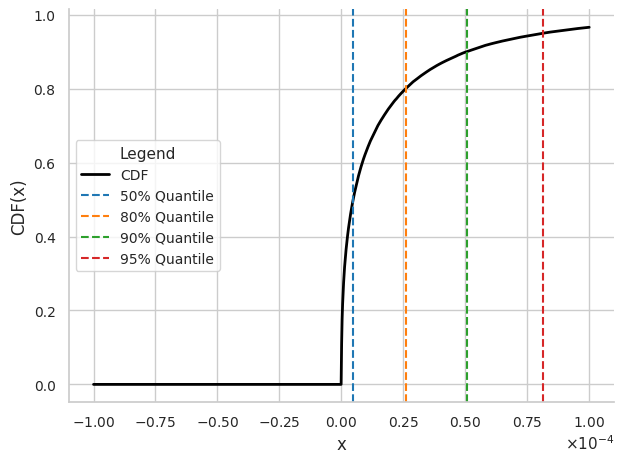

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

ax.plot(ys_cbst, cdf_vals_cbst, label='CDF', color='black', linewidth=2)

ax.axvline(quant50_cbst, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_cbst, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_cbst, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_cbst, linestyle='--', color='#d62728', label='95% Quantile')

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

# Scientific notation formatter
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 4))  # Use scientific notation if exponent < -3 or > 4
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

### Difference of Dirichlets CDF

#### Evaluate at a single point

In [ ]:
n_leaves = 1000
tree = pcms.tree.cbst(n_leaves=n_leaves)
y = 0.04
eps = 0.01
delta = 0.01

In [ ]:
node = np.random.choice(tree.find_interior_nodes())

In [ ]:
cdf_val_dod = pcms.haar.cdf_proj_dod(y, tree, node=node)

In [ ]:
print(cdf_val_dod)

1.0


#### Evaluate at multiple points

In [ ]:
n_points = 1000
ys_dod = np.linspace(-0.01, 0.01, n_points)

In [ ]:
cdf_vals_dod = pcms.haar.cdf_proj_dod(ys_dod, tree, node=node)

In [ ]:
quantile_levels = [0.5, 0.8, 0.9, 0.95]
quantiles_dod = np.interp(quantile_levels, cdf_vals_dod, ys_dod)
quant50_dod, quant80_dod, quant90_dod, quant95_dod = quantiles_dod

In [ ]:
print(quant50_dod, quant80_dod, quant90_dod, quant95_dod)

1.5737386871405864e-06 0.0024869083643030004 0.003909793664632373 0.005174799799799798


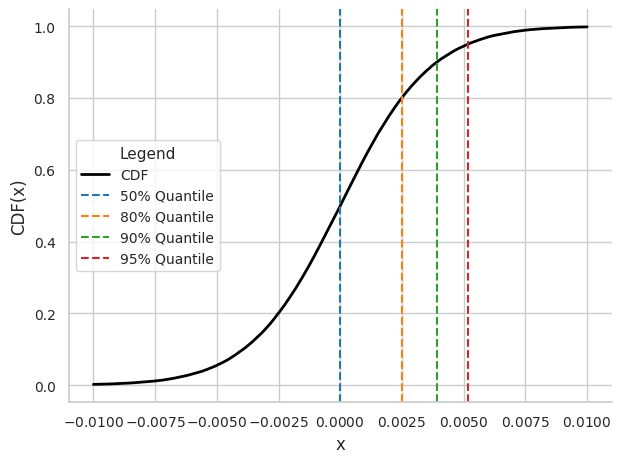

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

ax.plot(ys_dod, cdf_vals_dod, label='CDF', color='black', linewidth=2)

ax.axvline(quant50_dod, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_dod, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_dod, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_dod, linestyle='--', color='#d62728', label='95% Quantile')

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

# Scientific notation formatter
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 4))  # Use scientific notation if exponent < -3 or > 4
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

## Part 2: Level of significance of Haar-like coordiantes of Guerrero Negro microbial mat dataset against 97% Greengenes tree

### Load 97% Greengenes tree

In [4]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

In [5]:
interior_nodes = tree.find_interior_nodes()
tax_filepath = os.path.join(GG_DATA, 'taxonomy/97_otu_taxonomy.txt')

### Load Guerrero Negro dataset

In [6]:
gn_table_filepath = os.path.join(GN_DATA, '454/47908_otu_table.tsv')
table_df = utils.load_gn_seq_id_abundances(gn_table_filepath)

In [7]:
# Convert counts to proportions
cols = table_df.columns[1:]
table_df[cols] = table_df[cols].div(table_df[cols].sum(axis=0), axis=1)

# Append leaf index column
leaf_idxs = seq_id2leaf_idx[table_df['OTU ID']].values
table_df.loc[:, 'Leaf Index'] = leaf_idxs
table_df.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [8]:
print(table_df)

       OTU ID  1200.GN01P  1200.GN01P.o  1200.GN02P  1200.GN02P.o  1200.GN03P  \
0     2773512    0.000000           0.0    0.000000      0.000602    0.000000   
1     4361967    0.000000           0.0    0.000000      0.000602    0.000000   
2     3675511    0.001170           0.0    0.001155      0.000000    0.000696   
3     2877492    0.000000           0.0    0.000578      0.000000    0.001392   
4     4481520    0.000000           0.0    0.000000      0.000000    0.008351   
...       ...         ...           ...         ...           ...         ...   
1700  4331263    0.000000           0.0    0.000000      0.000000    0.000000   
1701   252805    0.000585           0.0    0.001733      0.003008    0.000696   
1702  4453795    0.000000           0.0    0.000000      0.000000    0.001392   
1703  1549742    0.000000           0.0    0.000000      0.000000    0.000000   
1704  1636411    0.000000           0.0    0.000000      0.000000    0.000000   

      1200.GN03P.o  1200.GN

### Compute Haar-like coordinates

In [44]:
Q, S = pcms.haar.sparsify(tree)

In [45]:
diff_s = table_df['1200.GN09P.o'] - table_df['1200.GN01P.o']

mask = diff_s != 0

values = diff_s[mask].values
indices = table_df['Leaf Index'][mask].values
indptr = [0, len(values)]

diff = csc_matrix((values, indices, indptr), shape=(n_leaves,1))

In [46]:
coords = (Q.T @ diff).tocsc()

In [47]:
coords.indptr

array([   0, 4271], dtype=int32)

In [48]:
values = coords.data**2 * S.diagonal()[coords.indices]
indices = coords.indices[values != 0]
values = values[values != 0]
indptr = np.array([0, values.size], dtype=np.int32)
dh_coords = csc_matrix((values, indices, indptr))

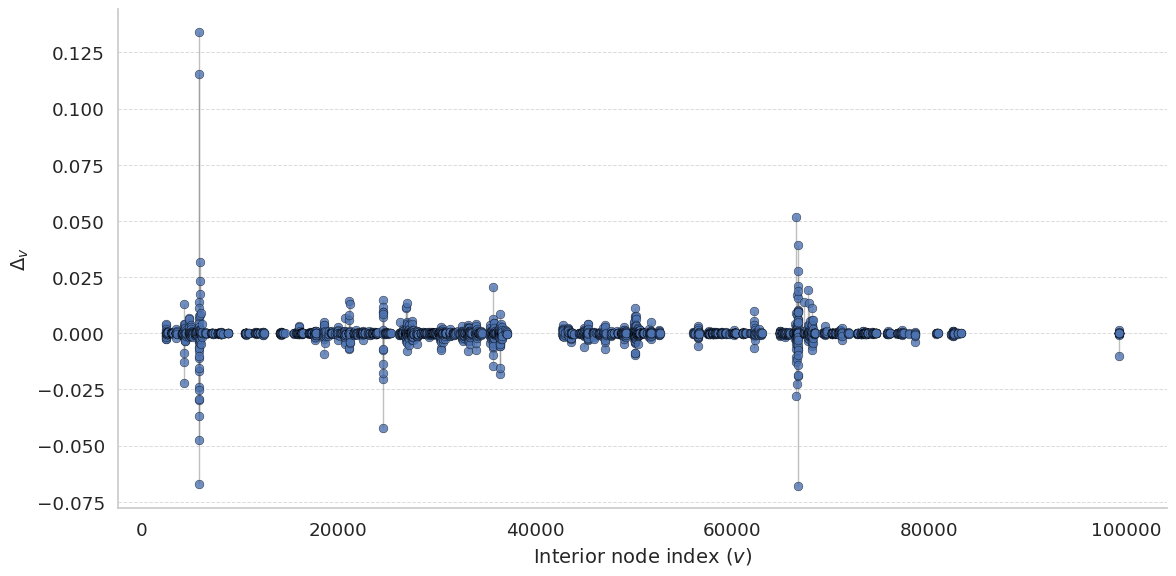

In [49]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points colored by value with better aesthetics
scatter = ax.scatter(
    coords.indices[:-1],
    coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Draw vertical lines behind scatter points
ax.vlines(
    x=coords.indices,
    ymin=0,
    ymax=coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Improve axes labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

# Add a grid on y-axis only for clarity
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()

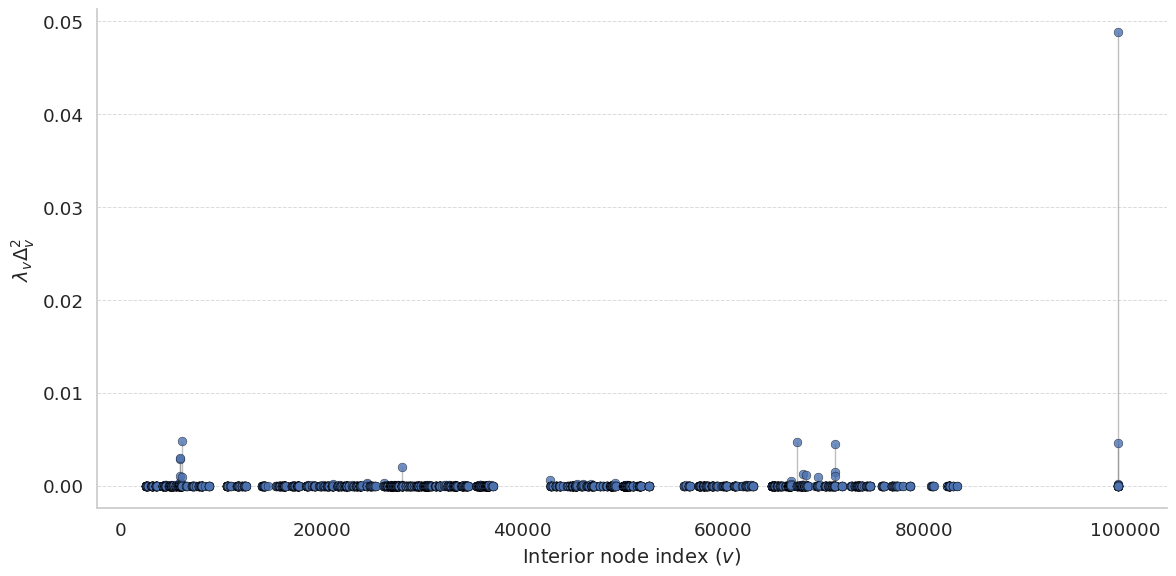

In [67]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points with subtle edge for clarity
scatter = ax.scatter(
    dh_coords.indices[:-1],
    dh_coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Vertical lines behind scatter points
ax.vlines(
    x=dh_coords.indices,
    ymin=0,
    ymax=dh_coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

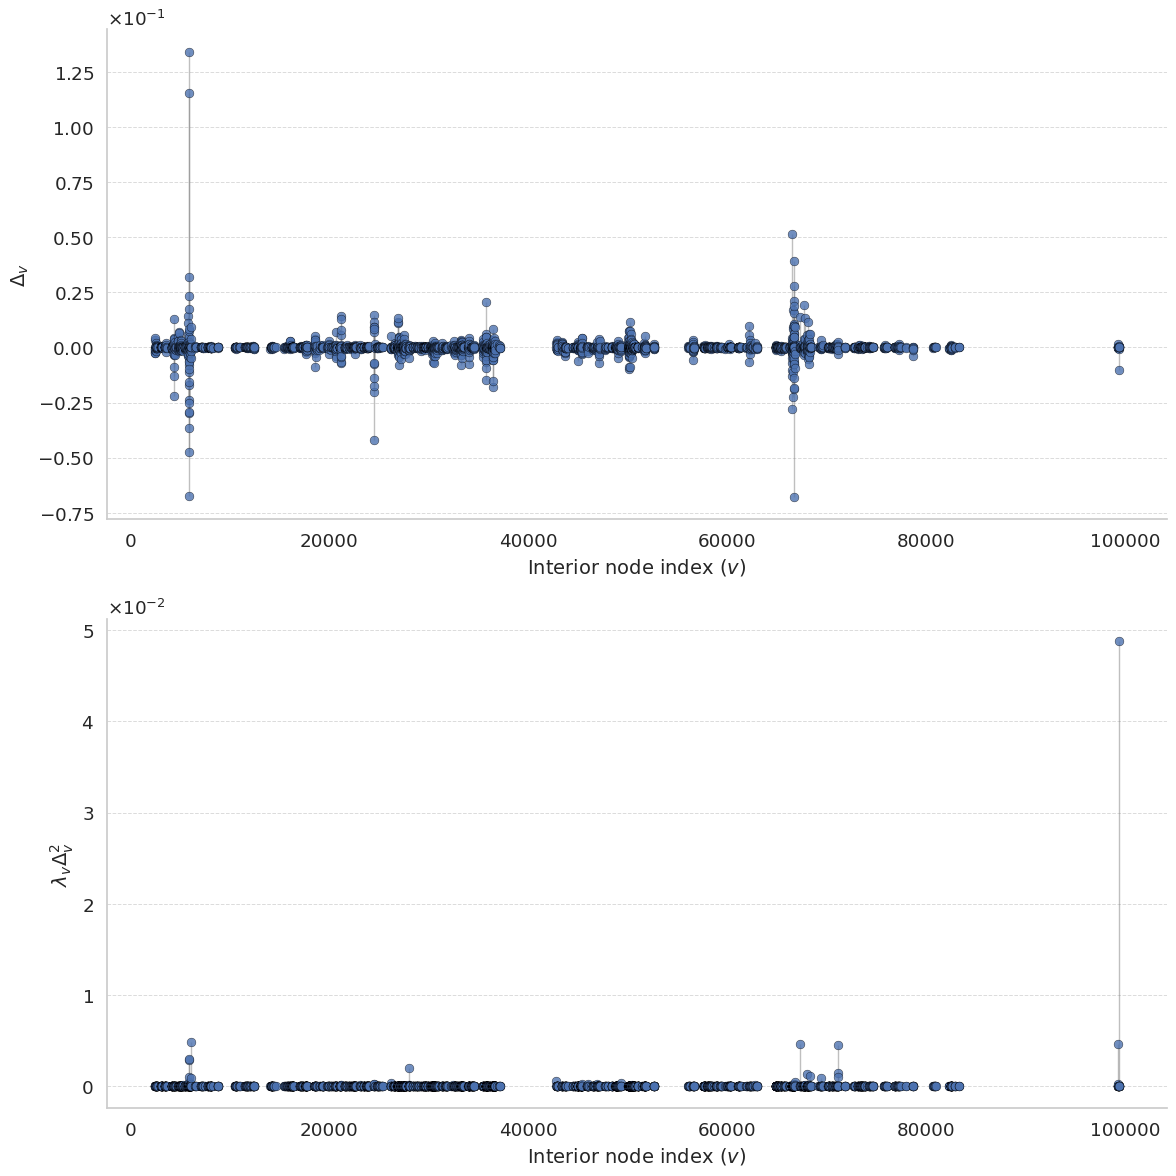

In [51]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharey=False)

# --- Plot 1: coords plot ---
scatter1 = ax1.scatter(
    coords.indices[:-1],
    coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
ax1.vlines(
    x=coords.indices,
    ymin=0,
    ymax=coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax1.set_xlabel('Interior node index ($v$)', fontsize=14)
ax1.set_ylabel(r'$\Delta_v$', fontsize=14)
ax1.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax1.xaxis.grid(False)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax1)

# --- Plot 2: dh_coords plot ---
scatter2 = ax2.scatter(
    dh_coords.indices[:-1],
    dh_coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
ax2.vlines(
    x=dh_coords.indices,
    ymin=0,
    ymax=dh_coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax2.set_xlabel('Interior node index ($v$)', fontsize=14)
ax2.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax2.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax2.xaxis.grid(False)
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

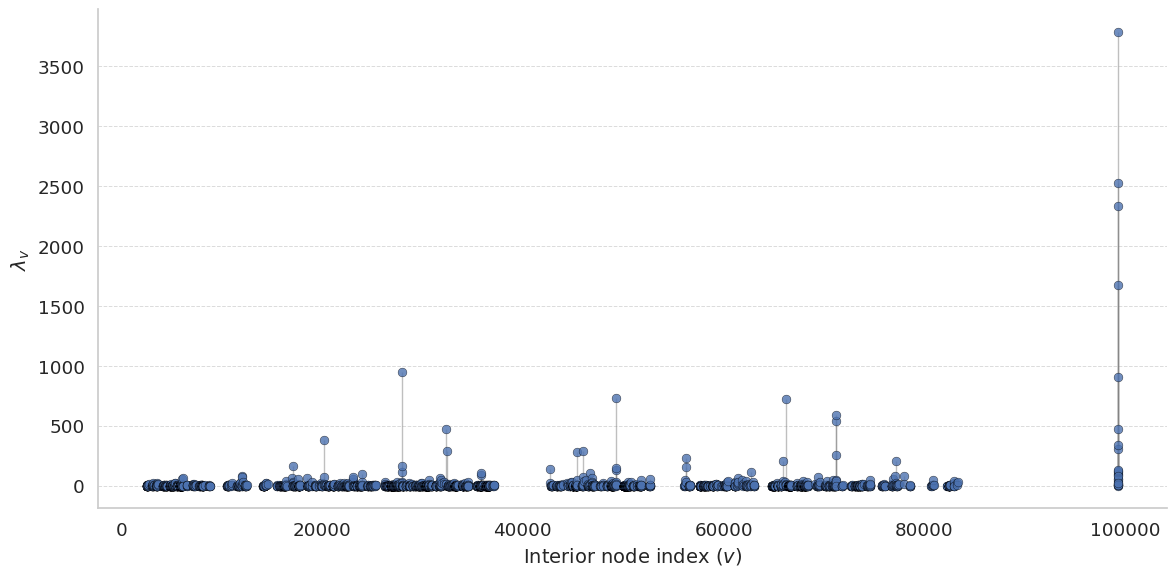

In [62]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points with subtle edge for clarity
scatter = ax.scatter(
    dh_coords.indices[:-1],
    S.diagonal()[dh_coords.indices[:-1]],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Vertical lines behind scatter points
ax.vlines(
    x=dh_coords.indices[:-1],
    ymin=0,
    ymax=S.diagonal()[dh_coords.indices[:-1]],
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

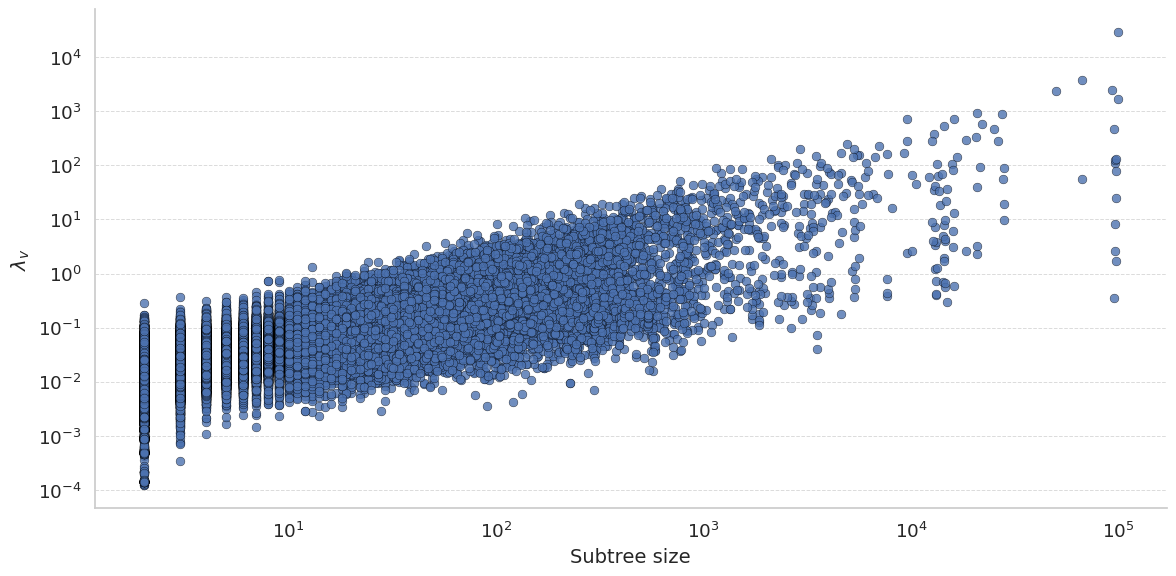

In [64]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points with subtle edge for clarity
scatter = ax.scatter(
    tree.get_subtree_size()[tree.find_interior_nodes()],
    S.diagonal(),
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Labels
ax.set_xlabel('Subtree size', fontsize=14)
ax.set_ylabel(r'$\lambda_v$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

ax.set_xscale('log')
ax.set_yscale('log')

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

### Compute level of significance

#### Edge length distribution

In [31]:
edge_lengths = tree.get_edge_length()
subtree_sizes = tree.get_subtree_size()

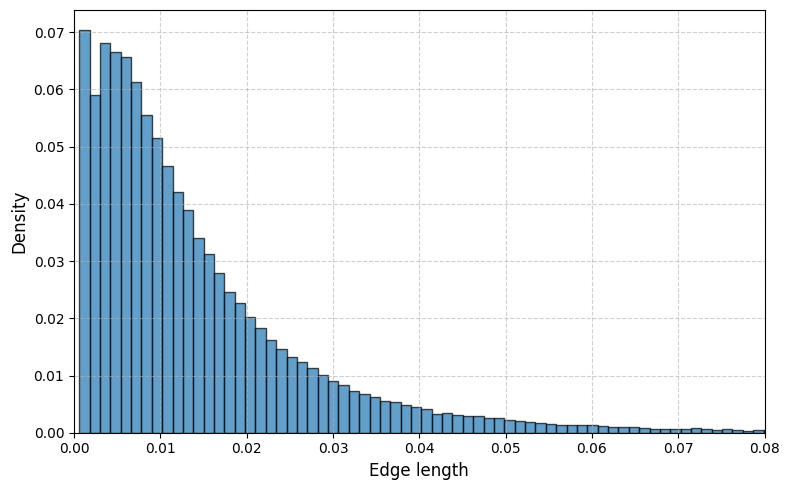

In [32]:
n_bins = int(np.sqrt(tree.n_nodes))
pdf_values, bins = np.histogram(edge_lengths, bins=n_bins, density=True)
pdf_values /= pdf_values.sum()
bin_widths = bins[:-1] - bins[1:]

output_path = "../data/gg_97_otus_edge_length_distribution.csv"
np.savetxt(
    output_path,
    np.column_stack([bins[1:], pdf_values]),
    delimiter=",",
    header="bin_center,pdf_value",
    comments=''
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(bins[1:], pdf_values, width=bin_widths, color='C0', edgecolor='black', alpha=0.7, label='PDF')
ax.set_xlim(0, 0.08)
ax.set_ylim(bottom=0)
ax.set_xlabel('Edge length', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.grid(visible=True, linestyle='--', alpha=0.6)
fig.tight_layout()
plt.show()

##### Helper function

In [ ]:
def make_hist(ax, data, title, xlabel, color, cdf=False, discrete=False):
    n_bins = int(np.sqrt(len(data)))
    pdf_values, bins = np.histogram(data, bins=n_bins, density=True)
    if discrete or cdf:
        pdf_values /= pdf_values.sum()
    bin_widths = bins[:-1] - bins[1:]

    if cdf:
        ax.bar(bins[1:], pdf_values.cumsum(), width=bin_widths,
               color=color, edgecolor='black', alpha=0.7, label='PDF')
    else:
        ax.bar(bins[1:], pdf_values, width=bin_widths,
               color=color, edgecolor='black', alpha=0.7, label='PDF')
    ax.set_xlim(0, 0.08)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(xlabel, fontsize=12)
    if cdf:
        ax.set_ylabel('Cumulative Density', fontsize=12)
    else:
        ax.set_ylabel('Density', fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.grid(visible=True, linestyle='--', alpha=0.6)

##### Does the distribution depend on depth?

In [ ]:
leaves, leaf_depths = tree.find_leaves(return_depths=True)
interior_nodes, interior_node_depths = tree.find_interior_nodes(return_depths=True)

In [ ]:
nodes = np.concatenate((leaves, interior_nodes))
depths = np.concatenate((leaf_depths, interior_node_depths))

In [ ]:
unique_depths, counts = np.unique(depths, return_counts=True)

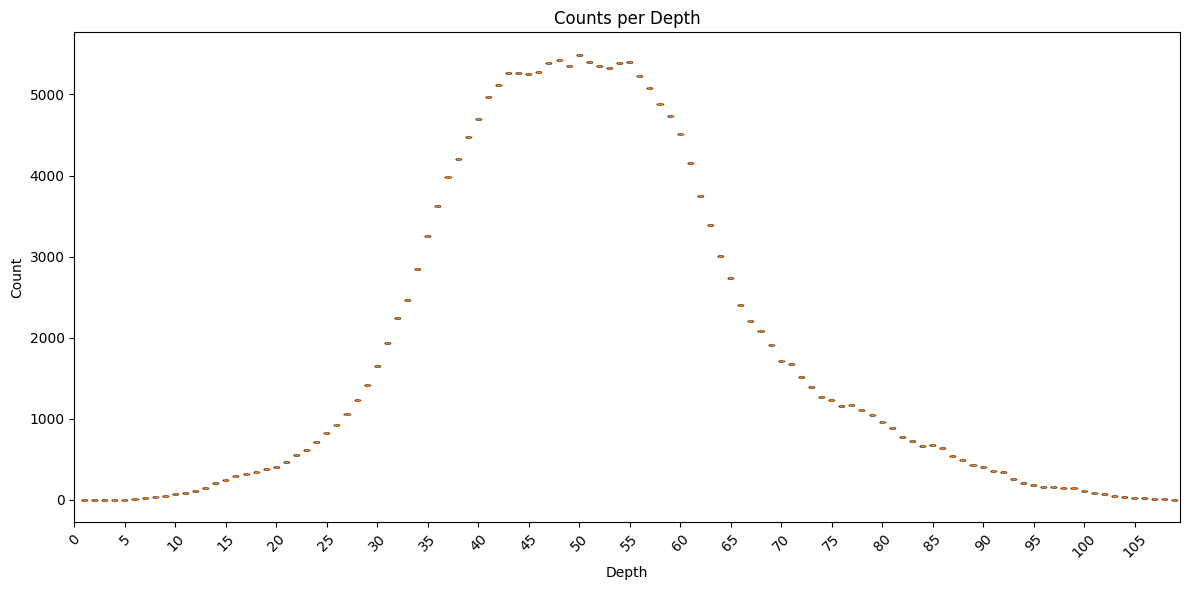

In [ ]:
data_for_boxplot = [[count] for count in counts]

plt.figure(figsize=(12,6))
plt.boxplot(data_for_boxplot, tick_labels=unique_depths)
plt.xlabel("Depth")
plt.ylabel("Count")
plt.title("Counts per Depth")

step = 5
xticks = range(0, len(unique_depths), step)
plt.xticks(xticks, [unique_depths[i] for i in xticks], rotation=45)

plt.tight_layout()
plt.show()

##### Is there a change in distribution over the total sequence?

In [ ]:
indxs_subtree_size = np.argsort(subtree_sizes)

In [ ]:
start_time = time.time()
T_obs_total, Ts_total, F_obs_total = kspt.max_split_ks_perm_test(edge_lengths[indxs_subtree_size])
print("Elapsed time: ", time.time() - start_time)

In [ ]:
print(f"T_obs: {T_obs_total:0.5e}, p: {1-F_obs_total:0.5e}")

T_obs: 3.80810e-01, p: 0.00000e+00


In [ ]:
left = edge_lengths[indxs_subtree_size][:edge_lengths.size//2]
right = edge_lengths[indxs_subtree_size][edge_lengths.size//2:]

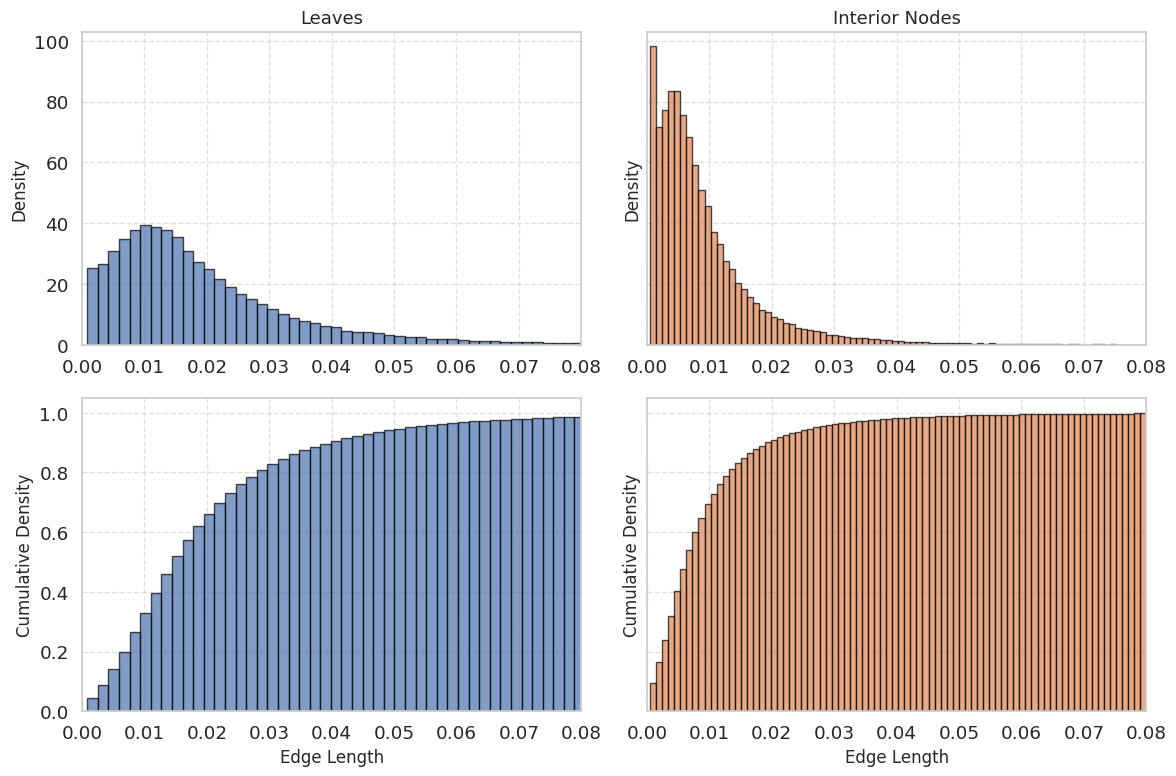

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey='row')

make_hist(axes[0][1], right, "Interior Nodes", "", "C1")
make_hist(axes[0][0], left, "Leaves", "", "C0")
make_hist(axes[1][1], right, "", "Edge Length", "C1", cdf=True)
make_hist(axes[1][0], left, "", "Edge Length", "C0", cdf=True)

fig.tight_layout()
plt.show()

##### Is there a change in distribution over the interior nodes?

In [ ]:
start_time = time.time()
T_obs_right, Ts_right, F_obs_right = kspt.max_split_ks_perm_test(right)
print("Elapsed time: ", time.time() - start_time)

Elapsed time:  117.85094738006592


In [ ]:
print(f"T_obs: {T_obs_right:0.5e}, p: {1-F_obs_right:0.5e}")

T_obs: 9.41020e-02, p: 0.00000e+00


In [ ]:
vals, counts = np.unique(subtree_sizes[indxs_subtree_size][tree.n_nodes//2:], return_counts=True)

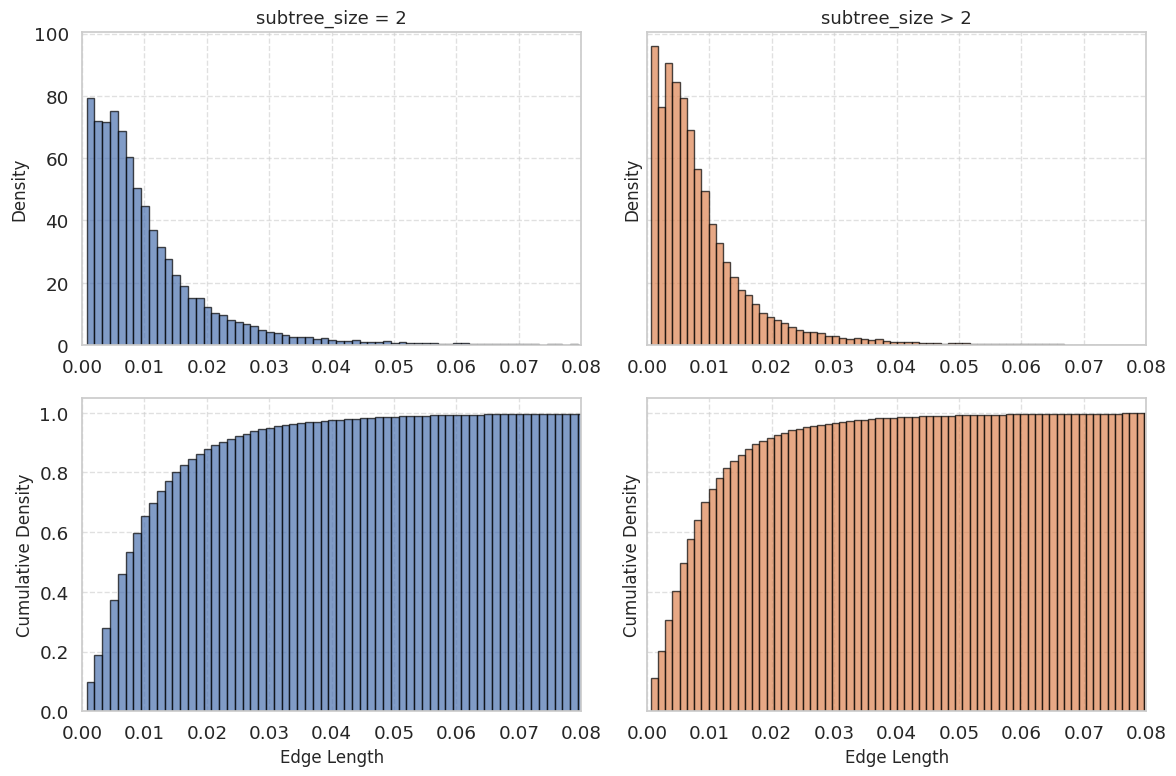

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey='row')

make_hist(axes[0][1], right[counts[0]:], "subtree_size > 2", "", "C1")
make_hist(axes[0][0], right[:counts[0]], "subtree_size = 2", "", "C0")
make_hist(axes[1][1], right[counts[0]:], "", "Edge Length", "C1", cdf=True)
make_hist(axes[1][0], right[:counts[0]], "", "Edge Length", "C0", cdf=True)

fig.tight_layout()
plt.show()

In [ ]:
counts

array([29967, 14968,  9140, ...,     1,     1,     2], shape=(1171,))

In [ ]:
start_time = time.time()
T_obs_right3, Ts_right3, F_obs_right3 = kspt.max_split_ks_perm_test(right[counts[0]:])
print("Elapsed time: ", time.time() - start_time)

Elapsed time:  72.2391951084137


In [ ]:
print(f"T_obs: {T_obs_right3:0.5e}, p: {1-F_obs_right3:0.5e}")

T_obs: 7.10796e-02, p: 0.00000e+00


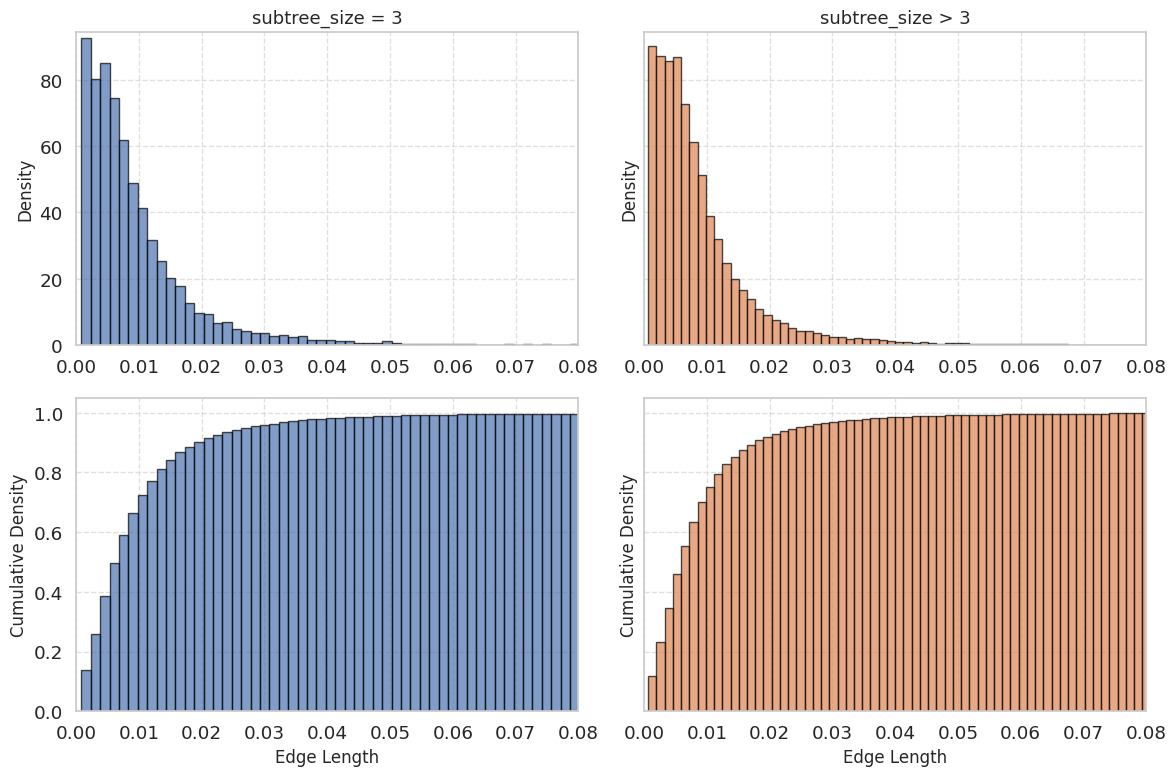

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey='row')

make_hist(axes[0][1], right[counts[0]+counts[1]:], "subtree_size > 3", "", "C1")
make_hist(axes[0][0], right[counts[0]:counts[0]+counts[1]], "subtree_size = 3", "", "C0")
make_hist(axes[1][1], right[counts[0]+counts[1]:], "", "Edge Length", "C1", cdf=True)
make_hist(axes[1][0], right[counts[0]:counts[0]+counts[1]], "", "Edge Length", "C0", cdf=True)

fig.tight_layout()
plt.show()

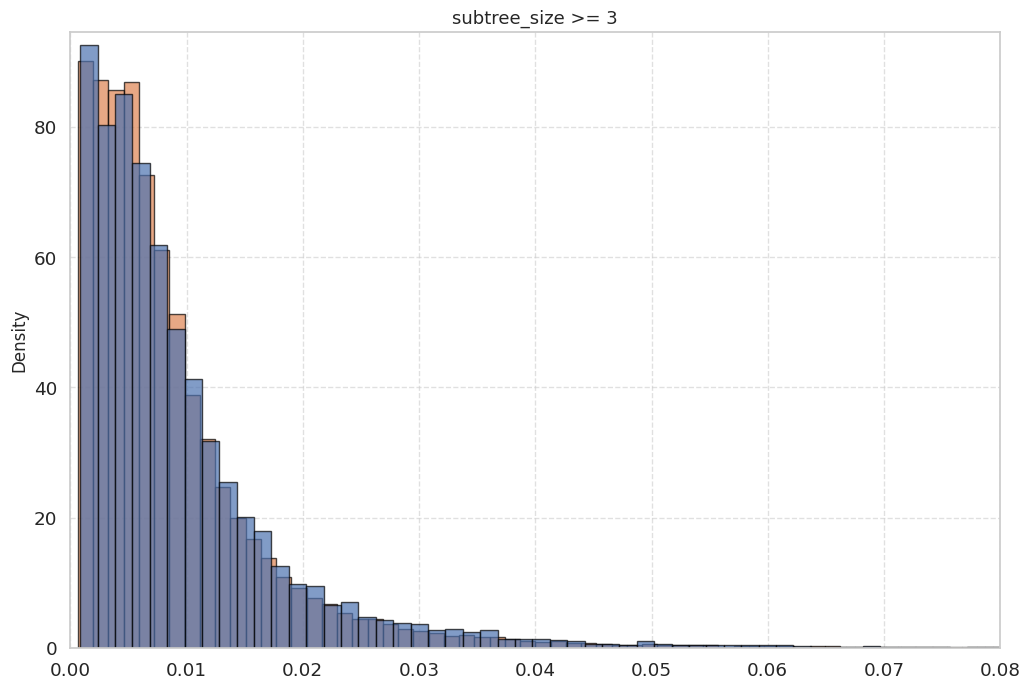

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharey='row')

make_hist(axes, right[counts[0]+counts[1]:], "subtree_size >= 3", "", "C1")
make_hist(axes, right[counts[0]:counts[0]+counts[1]], "subtree_size >= 3", "", "C0")

##### Is child edge length correlated with parent edge length?

In [34]:
avg_child_edge_lengths = []
interior_nodes = tree.find_interior_nodes()
for i in interior_nodes:
    children = tree.find_children(i)
    child_lengths = [edge_lengths[c] for c in children]
    avg_child_edge_lengths.append(np.mean(child_lengths))
avg_child_edge_lengths = np.asarray(avg_child_edge_lengths)

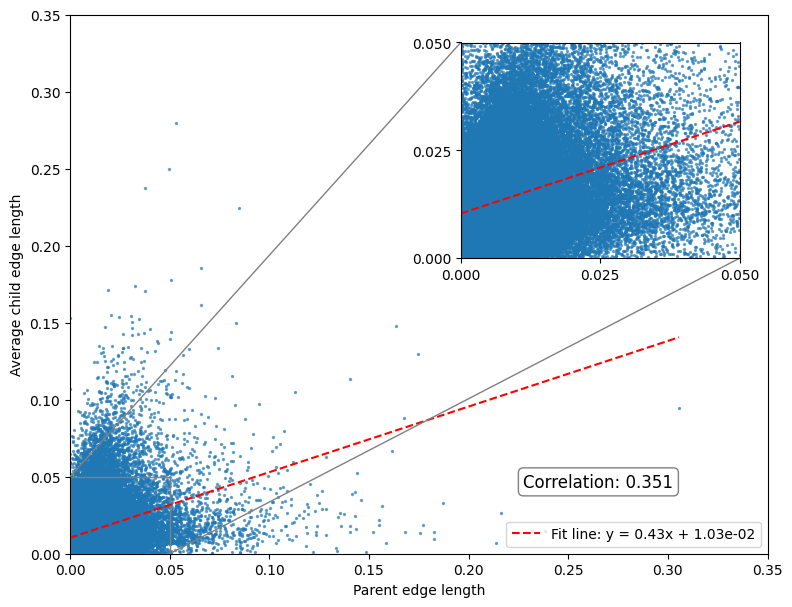

In [35]:
fig, ax = plt.subplots(figsize=(9,7))

# Compute correlation coefficient
corr = np.corrcoef(avg_child_edge_lengths, edge_lengths[interior_nodes])[0, 1]

# Linear regression parameters (y = m*x + b)
m, b = np.polyfit(edge_lengths[interior_nodes], avg_child_edge_lengths, 1)

# Scatter plot full range
ax.scatter(edge_lengths[interior_nodes], avg_child_edge_lengths, s=2, alpha=0.6)
ax.set_xlabel("Parent edge length")
ax.set_ylabel("Average child edge length")

# Plot the best fit line on full range
x_vals = np.array([edge_lengths[interior_nodes].min(), edge_lengths[interior_nodes].max()])
y_vals = m * x_vals + b
ax.plot(x_vals, y_vals, 'r--', label=f"Fit line: y = {m:.2f}x + {b:.2e}")

ax.set_xlim(edge_lengths[interior_nodes].min(), 0.35)
ax.set_ylim(avg_child_edge_lengths.min(), 0.35)

# Add correlation coefficient text
ax.text(0.65, 0.15, f"Correlation: {corr:.3f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))

# Create inset axes for zoomed plot
axins = inset_axes(ax, width="40%", height="40%", loc='upper right', borderpad=2)

# Scatter zoomed in
axins.scatter(edge_lengths[interior_nodes], avg_child_edge_lengths, s=2, alpha=0.6)

# Zoomed best fit line (same slope/intercept)
x_zoom = np.array([0, 0.05])
y_zoom = m * x_zoom + b
axins.plot(x_zoom, y_zoom, 'r--')

axins.set_xlim(0, 0.05)
axins.set_ylim(0, 0.05)
axins.set_xticks([0, 0.025, 0.05])
axins.set_yticks([0, 0.025, 0.05])

# Draw rectangle on main plot showing zoom region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.legend(loc='lower right')
plt.show()

##### Conditional quantile estimator

In [6]:
subtree_sizes = tree.get_subtree_size()
subtree_starts = tree.find_subtree_start_indices()
interior_nodes, interior_node_depths = tree.find_interior_nodes(return_depths=True)
leaves, leaf_depths = tree.find_leaves(return_depths=True)

In [7]:
trace_lengths = []
depth_deltas = []
for intr_idx, u in enumerate(interior_nodes):
    start = subtree_starts[u]
    size = subtree_sizes[u]
    idxs = np.arange(start, start+size)
    depth = interior_node_depths[intr_idx]
    for leaf, leaf_depth in zip(leaves[idxs], leaf_depths[idxs]):
        trace_lengths.append(tree.find_tbl(leaf, u))
        depth_deltas.append(leaf_depth - depth)
trace_lengths = np.asarray(trace_lengths)
depth_deltas = np.asarray(depth_deltas)

In [8]:
vals, counts = np.unique(depth_deltas, return_counts=True)

In [9]:
sort_idxs = np.argsort(depth_deltas)

(array([3683034.,  304526.,  138634.,  278711.,  254495.,   79951.,
         165795.,  120320.,   41803.,   51376.]),
 array([5.60000000e-04, 4.41076989e+03, 8.82153922e+03, 1.32323086e+04,
        1.76430779e+04, 2.20538472e+04, 2.64646166e+04, 3.08753859e+04,
        3.52861552e+04, 3.96969245e+04, 4.41076939e+04]),
 <BarContainer object of 10 artists>)

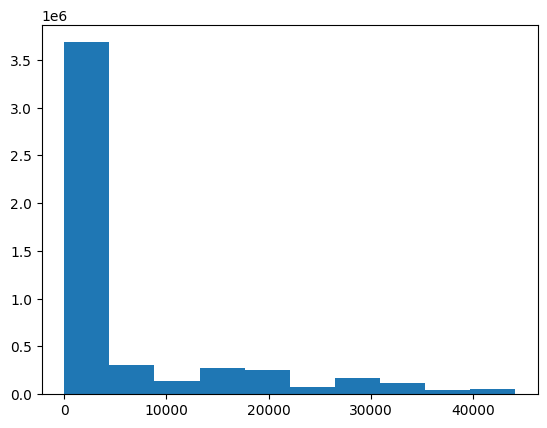

In [12]:
plt.hist(trace_lengths)

#### Random topology CDF

In [ ]:
N = 10

interior_nodes = tree.find_interior_nodes()[coords.indices]
subtree_sizes = tree.get_subtree_size()[interior_nodes]
subtree_starts = tree.find_subtree_start_indices()[interior_nodes]

sort_idx = np.argsort(dh_coords[:-1])[::-1]
ordered_coords = coords.data[sort_idx]
ordered_indices = coords.indices[sort_idx]
ordered_dh_coords = dh_coords[sort_idx]
ordered_dh_coords.indices = dh_coords.indices[sort_idx]
ordered_subtree_sizes = subtree_sizes[sort_idx]
ordered_subtree_starts = subtree_starts[sort_idx]

In [ ]:
start_time = time.time()

print(f"{'Index':>10} {'Subtree Size':>14} {'Component':>10} {'P-Value':>10} {'Name':>10}")
print("-" * 48)

for idx in range(N):
    start = ordered_subtree_starts[idx]
    width = ordered_subtree_sizes[idx]
    func = diff[start:start + width].toarray().reshape(-1)
    cdf_val = pcms.haar.cdf_proj_cbst(
        ordered_dh_coords[idx], 
        f=func,
        eps=0.005,
        delta=0.01,
        batch_size=1000
    )
    pval = 2 * min(cdf_val, 1 - cdf_val)
    node_idx = ordered_dh_coords.indices[idx]
    print(f"{ordered_dh_coords.indices[idx]+1:>10} {ordered_subtree_sizes[idx]:>14} {ordered_dh_coords[idx]:>10.4f} {pval:>10.3e} {tree.get_name(node_idx)}")

print("\nElapsed time: ", time.time() - start_time)

     Index   Subtree Size  Component    P-Value
------------------------------------------------
     99311          95297     0.0488  0.000e+00
      6079           1792     0.0048  1.285e-02
     67317            835     0.0047  3.850e-03
     99307          50035     0.0046  3.775e-05
     71160          14472     0.0045  5.662e-05
      5923            600     0.0030  9.913e-02
      5921            240     0.0029  2.215e-01
     27998          20765     0.0020  5.662e-05
     71159           4899     0.0014  4.228e-03
     67959           1477     0.0013  2.520e-02

Elapsed time:  717.2858076095581


#### Difference of Dirichlet CDF

In [52]:
start = time.time()

pvals_dod = np.zeros(coords.data.shape)
for i_idx, j_idx in enumerate(tree.find_interior_nodes()[coords.indices]):
    children = tree.find_children(j_idx)
    if children.size == 1:
        pvals_dod[i_idx] = 1.0
    else:
        cdf_val = pcms.haar.cdf_proj_dod(
            coords.data[i_idx], 
            tree=tree,
            node=j_idx,
            eps=0.01,
            delta=0.01
        )
        pvals_dod[i_idx] = 2 * min(cdf_val, 1 - cdf_val)

print("Elapsed time: ", time.time() - start)

Elapsed time:  20.374526023864746


In [53]:
alpha = 0.05
do_reject_dod = pvals_dod < alpha

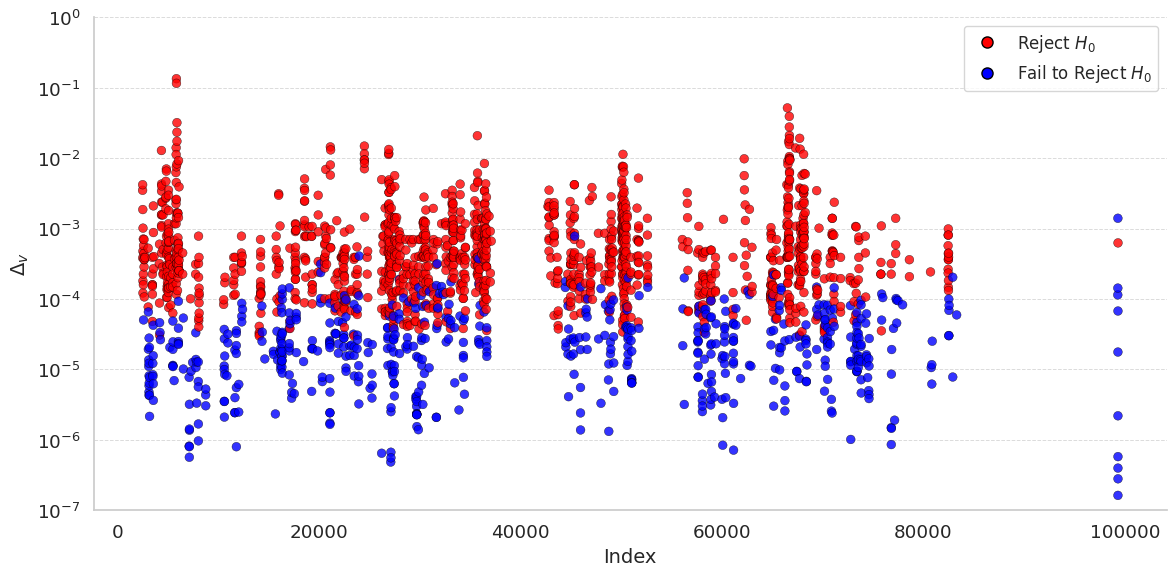

In [54]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to colors: True → red, False → blue
colors = np.where(do_reject_dod[:-1], 'red', 'blue')

# Scatter with edge and higher zorder
scatter = ax.scatter(
    coords.indices[:-1],
    coords.data[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Use log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-7, 1])

# Custom legend with clearer labels and markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Axis labels
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel(r'$\Delta_{v}$', fontsize=14)

# Add y-axis grid only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove clutter
sns.despine()

plt.tight_layout()
plt.show()

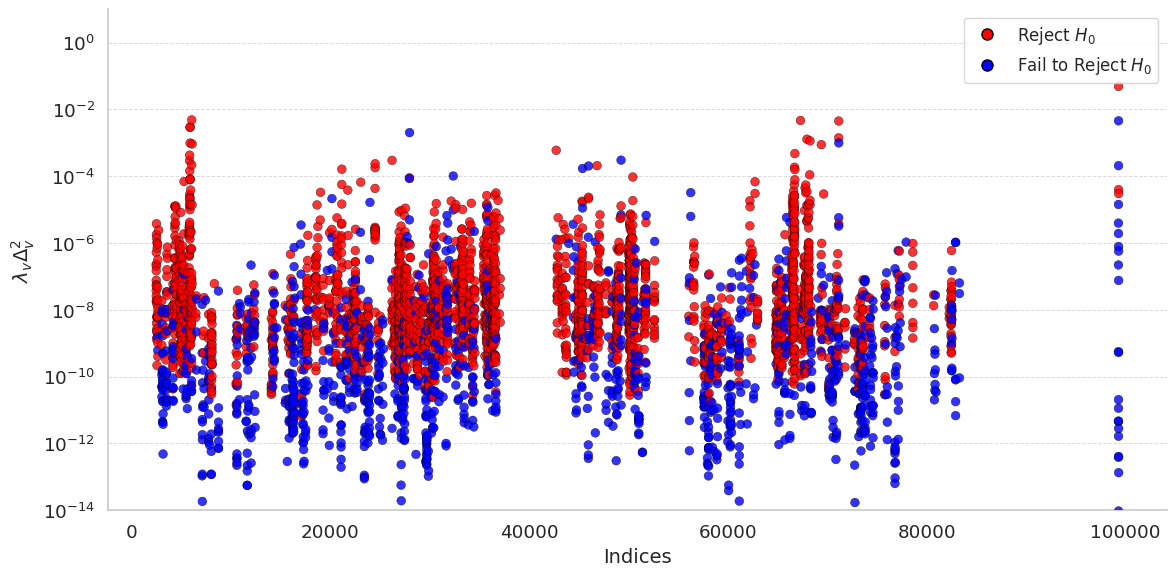

In [55]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to binary colors: True → red, False → blue
colors = np.where(do_reject_dod[:-1], 'red', 'blue')

# Scatter plot with edge color for clarity
scatter = ax.scatter(
    dh_coords.indices[:-1],
    dh_coords.data[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-14, 1e1])

# Custom legend with edge color to match scatter
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Labels
ax.set_xlabel('Indices', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Clean up plot spines
sns.despine()

plt.tight_layout()
plt.show()

In [56]:
N = 10

interior_nodes = tree.find_interior_nodes()[coords.indices]
subtree_sizes = tree.get_subtree_size()[interior_nodes]
subtree_starts = tree.find_subtree_start_indices()[interior_nodes]

sort_idx = np.argsort(dh_coords.data[:-1])[::-1]
ordered_coords = coords.data[sort_idx]
ordered_indices = coords.indices[sort_idx]
ordered_dh_coords = dh_coords.data[sort_idx]
ordered_dh_indices = dh_coords.indices[sort_idx]
ordered_subtree_sizes = subtree_sizes[sort_idx]
ordered_subtree_starts = subtree_starts[sort_idx]
ordered_nodes = interior_nodes[sort_idx]

print(f"{'Index':>10} {'Subtree Size':>14} {'Component':>10} {'P-Value':>10}")
print("-" * 60)

for idx in range(N):
    cdf_val = pcms.haar.cdf_proj_dod(
        ordered_coords[idx], 
        tree=tree,
        node=ordered_nodes[idx],
        eps=0.0005,
        delta=0.0001
    )
    pval = 2 * min(cdf_val, 1 - cdf_val)
    print(f"{ordered_dh_indices[idx]+1:>10} {ordered_subtree_sizes[idx]:>14} {ordered_dh_coords[idx]:>10.4f} {pval:>10.3e}")

     Index   Subtree Size  Component    P-Value
------------------------------------------------------------
     99311          95297     0.0488  0.000e+00
      6079           1792     0.0048  0.000e+00
     67317            835     0.0047  0.000e+00
     99307          50035     0.0046  3.759e-01
     71160          14472     0.0045  3.704e-04
      5923            600     0.0030  0.000e+00
      5921            240     0.0029  0.000e+00
     27998          20765     0.0020  1.407e-01
     71159           4899     0.0014  3.029e-07
     67959           1477     0.0013  0.000e+00


### Taxonomic classification of splits

In [57]:
interior_nodes = tree.find_interior_nodes()

In [58]:
def tax_of_split(idx):
    tax_map_left = utils.build_gg_otu_id2tax_map(tree, tax_filepath, node=tree.get_child(interior_nodes[idx]))
    tax_map_right = utils.build_gg_otu_id2tax_map(tree, tax_filepath, node=tree.get_sibling(tree.get_child(interior_nodes[idx])))
    return tax_map_left, tax_map_right

In [59]:
def truncate_lcr(lcr: str, max_ranks: int = 3) -> str:
    """
    Truncate an LCR string from the left by keeping only the last `max_ranks` ranks.
    Prepend with '...' if any ranks were removed.
    """
    ranks = lcr.split(';')
    if len(ranks) > max_ranks:
        return '...;' + ';'.join(ranks[-max_ranks:])
    else:
        return lcr


def format_tax_table(idxs, max_ranks=3, file=sys.stdout):
    node_blocks = []

    # First pass: collect truncated LCRs and abundance lines
    for idx in idxs:
        left, right = tax_of_split(idx)
        left_abund_lines = [f"{tax}:{frac:.2f}" for tax, frac in left['RelAbundances'].items() if round(frac, 2) > 0.0]
        right_abund_lines = [f"{tax}:{frac:.2f}" for tax, frac in right['RelAbundances'].items() if round(frac, 2) > 0.0]

        left_lcr_trunc = truncate_lcr(left['LCR'], max_ranks)
        right_lcr_trunc = truncate_lcr(right['LCR'], max_ranks)

        node_blocks.append((idx, left_lcr_trunc, right_lcr_trunc, left_abund_lines, right_abund_lines))

    # Compute column widths across all nodes after truncation
    left_max_width = max(len(block[1]) for block in node_blocks)  # LCR
    right_max_width = max(len(block[2]) for block in node_blocks)
    # Also consider abundances
    for _, _, _, left_abund, right_abund in node_blocks:
        if left_abund:
            left_max_width = max(left_max_width, max(len(l) for l in left_abund))
        if right_abund:
            right_max_width = max(right_max_width, max(len(r) for r in right_abund))
    left_max_width += 4
    right_max_width += 4

    # Print table
    for idx, left_lcr, right_lcr, left_abund_lines, right_abund_lines in node_blocks:
        # Pad abundance lines
        max_lines = max(len(left_abund_lines), len(right_abund_lines))
        left_abund_lines += [""] * (max_lines - len(left_abund_lines))
        right_abund_lines += [""] * (max_lines - len(right_abund_lines))

        # Node header
        print(f"Node {idx+1}", file=file)
        print(f"{'Left subtree':<{left_max_width}}{'Right subtree':<{right_max_width}}", file=file)
        print(f"{'-'*left_max_width}{'-'*right_max_width}", file=file)

        # LCR line
        print(f"{left_lcr:<{left_max_width}}{right_lcr:<{right_max_width}}", file=file)

        # Abundance lines
        for l_line, r_line in zip(left_abund_lines, right_abund_lines):
            print(f"{l_line:<{left_max_width}}{r_line:<{right_max_width}}", file=file)

        print("", file=file)  # Blank line between nodes

In [60]:
idxs = [99310, 6078, 67316, 99306, 71159, 5922, 5920, 27997, 71158, 67958]
with open("../data/tax_table_output.txt", "w") as f:
    format_tax_table(idxs, max_ranks=2, file=f)